In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from pathlib import Path
from typing import List, Literal

import mediapy as media
import numpy as np
import torch
import tqdm
from config_tools.common import get_typed_root_config
from einops import rearrange
from hydra import compose, initialize

# import ipython display
from IPython import display
from jacobian.dataset.pusher_dataset import Trajectory
from jacobian.utils.io import load_gzip_file, save_gzip_file
from mujoco_sim.env.base_env import RobotEnvCfg, RobotEnv
from raft_wrapper import InputPadder, RaftWrapper
from raft_wrapper.raft import resize_batched_flow, resize_batched_frames
from torchvision.utils import flow_to_image

# Tutorial 4: Controlling Robot with Jacobian Fields.

Author: [Sizhe Lester Li](https://sizhe-li.github.io/), PhD Student, MIT CSAIL

## A. Learning Outcomes
In this tutorial, I will demonstrate how to do visual inverse dynamics control using Jacobian Fields 

## B. Pusher Environment Description

The environment contains a spherical robotic pusher. The robot can move freely in 2D space and is steered by a 2D velocity command $\delta u \triangleq (x, y)$, where $x, y \in \mathbb{R}$.


## BibTeX
Please consider citing our work if you find that our work is helpful for your research endeavors :D
```
@misc{li2024unifying3drepresentationcontrol,
      title={Unifying 3D Representation and Control of Diverse Robots with a Single Camera}, 
      author={Sizhe Lester Li and Annan Zhang and Boyuan Chen and Hanna Matusik and Chao Liu and Daniela Rus and Vincent Sitzmann},
      year={2024},
      eprint={2407.08722},
      archivePrefix={arXiv},
      primaryClass={cs.RO},
      url={https://arxiv.org/abs/2407.08722}, 
}
```


## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

# Load up the simulation environment

In [5]:
overrides = []

map_to_sim_root = Path("../../mujoco-phys-sim")
config_path = Path("phys_sim/configurations/left_finger.yaml")

with initialize(
    version_base=None, config_path=str(map_to_sim_root / config_path.parent)
):
    hydra_cfg = compose(
        config_name=str(config_path.name),
        overrides=overrides,
    )


env_cfg: RobotEnvCfg = get_typed_root_config(hydra_cfg, RobotEnvCfg)
env = RobotEnv(env_cfg, mj_model=None)
init_state = env.get_state()

Loading XML file /home/scene-rep-robot/scratch/neural-jacobian-field-public/mujoco-phys-sim/assets/mujoco/planar_hand_reorientation/scene_left_finger_only.xml


""

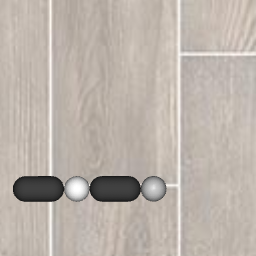

In [6]:
image = env.render("birdview")
media.show_image(image)

In [7]:
import torch
import numpy as np

from jacobian.train import PipelineCfg
from jacobian.models.model_wrapper_base import get_wrapper

device = torch.device("cuda:0")


config_path = Path("project/jacobian/configurations/config.yaml")

checkpoint_path = "./pretrained_ckpts/h918ryr7/model.ckpt"
model_name_kwrd = "transformer_jacobian"

overrides = [
    "dataset=left_finger",
    "wrapper=left_finger",
]


with initialize(version_base=None, config_path=str("../../" / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

wrapper = get_wrapper(cfg.wrapper)
model = wrapper.model

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is 

In [8]:
from jacobian.utils.wandb_ckpt import update_and_download_wandb_ckpt
checkpoint = torch.load(checkpoint_path)

msg = wrapper.load_state_dict(checkpoint["state_dict"], strict=False)
print(msg)

wrapper.eval()
wrapper.to(device)

print("finished loading model")

<All keys matched successfully>
finished loading model


### Implementing a trajectory tracker

1. **Converting a video into a "motion trajectory"**: we will use [cotrakcer](https://github.com/facebookresearch/co-tracker) for translating a video demonstration into a trajectory

2. **Trajectory tracking Details**. Please see Algorithm 1


""

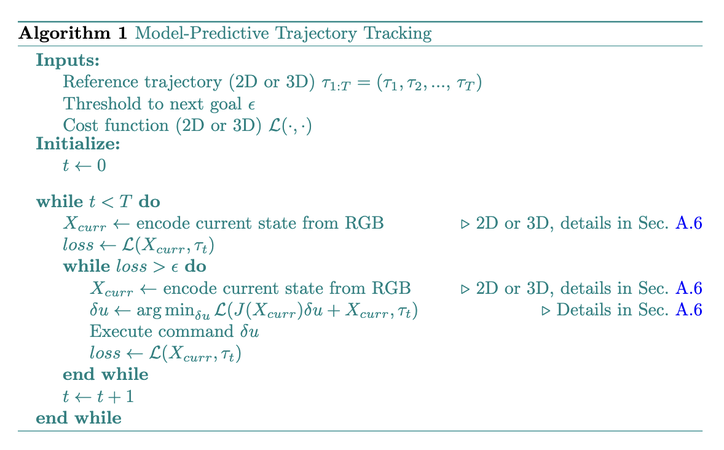

In [9]:
media.show_image(media.read_image("MPC_Tracking.png"), height=450)

In [10]:
import torch

cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker2").to(device)

Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_co-tracker_main


### Create a demonstration video

In [12]:
import numpy as np
from jacobian.utils.io import numpy_to_torch_image


qpos_limits = np.array(
    [
        [0, -1.4],  # min, max for the first joint
        [0, -1.4],  # min, max for the second joint
    ],
    dtype=np.float32,
)


#### create a sequence of qpos where only the first joint is moving
qpos0_seq = np.linspace(qpos_limits[0, 0], qpos_limits[0, 1], 30)
qpos1_seq = np.zeros_like(qpos0_seq)
qpos_seq_only_0 = np.stack([qpos0_seq, qpos1_seq], axis=1)


#### create a sequence of qpos where only the second joint is moving
qpos1_seq = np.linspace(qpos_limits[1, 0], qpos_limits[1, 1], 30)
qpos0_seq = np.zeros_like(qpos1_seq)
qpos_seq_only_1 = np.stack([qpos0_seq, qpos1_seq], axis=1)


def execute_trajectory(input_qpos_seq) -> Trajectory:

    traj_video = []
    for qpos_t in input_qpos_seq:
        env.sim.forward()
        env.sim.data.qpos[:2] = qpos_t
        env.sim.step()
        traj_video.append(env.render("birdview"))

    traj_video = np.stack(traj_video, axis=0)
    traj_qpos = input_qpos_seq.copy()

    traj_video_th = [numpy_to_torch_image(x) for x in traj_video]
    traj_video_th = torch.stack(traj_video_th, dim=0).to(device)
    # traj_flow = infer_raft_flow_over_torch_video(traj_video_th).cpu().numpy()

    traj_dict = {
        "seq_rgb_obs": traj_video[:-1],
        "seq_qpos": traj_qpos[:-1],
        # "seq_flow_obs": traj_flow,
    }

    print(
        f"""Shape of tensors
            seq_rgb_obs: {traj_dict["seq_rgb_obs"].shape}
            seq_qpos: {traj_dict["seq_qpos"].shape}
          """
    )

    return Trajectory(**traj_dict)

In [13]:
qpos1_seq = np.linspace(qpos_limits[1, 0], qpos_limits[1, 1], 30)
# randomly select a value from the qpos1 limits and repeat it to the same length as qpos0_seq
rand_qpos0 = np.random.uniform(qpos_limits[0, 0], qpos_limits[0, 1])
qpos0_seq = np.ones_like(qpos0_seq) * rand_qpos0

qpos_seq_rand_qpos0_walk_over_qpos1 = np.stack([qpos0_seq, qpos1_seq], axis=1)
trajectory_rand_qpos0_walk_over_qpos1 = execute_trajectory(
    qpos_seq_rand_qpos0_walk_over_qpos1
)


qpos0_seq = np.linspace(qpos_limits[0, 0], qpos_limits[0, 1], 30)
# randomly select a value from the qpos1 limits and repeat it to the same length as qpos0_seq
rand_qpos1 = np.random.uniform(qpos_limits[1, 0], qpos_limits[1, 1])
qpos1_seq = np.ones_like(qpos0_seq) * rand_qpos1

qpos_seq_rand_qpos1_walk_over_qpos0 = np.stack([qpos0_seq, qpos1_seq], axis=1)
trajectory_rand_qpos1_walk_over_qpos0 = execute_trajectory(
    qpos_seq_rand_qpos1_walk_over_qpos0
)

media.show_videos(
    [
        trajectory_rand_qpos0_walk_over_qpos1["seq_rgb_obs"],
        trajectory_rand_qpos1_walk_over_qpos0["seq_rgb_obs"],
    ],
    fps=10,
    titles=["only joint 0 moving", "only joint 1 moving"],
)

Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
          
Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
          


In [14]:
# import numpy as np

# traj_video = []
# traj_qpos = []

# def get_obs(env):
#     image = env.render("birdview")
#     qpos = env.data.get_body_xpos(f"pusher_main").copy()

#     traj_video.append(image)
#     traj_qpos.append(qpos)


# take a photo fo the mask
env.reset()
init_seg_mask = env.render("birdview", render_segmentation=True)

# # reset and generate a traj.
# env.reset()

# position_based_command = np.array([0.0, -0.82])
# horizon = 70
# for i in range(horizon):
#     env.step(position_based_command)

#     if get_obs is not None:
#         get_obs(env)

# media.show_video(traj_video)



### Translating the demonstration video to point tracks

In [9]:
from einops import rearrange

traj_video = np.stack(traj_video, axis=0)
traj_video_th = torch.from_numpy(traj_video).to(device).float()
traj_video_th = rearrange(traj_video_th, "t h w c -> () t c h w")

image_height, image_width = traj_video_th.shape[-2:]

init_seg_mask_th = torch.zeros(
    size=(image_height, image_width),
    dtype=torch.float32,
    device=device,
)

ids = init_seg_mask.copy()[..., 1]
for i in np.unique(ids):
    name: str = env.sim.model.geom_id2name(i)

    if "pusher" in name:
        init_seg_mask_th[ids == i] = 1.0

init_seg_mask_th = init_seg_mask_th.unsqueeze(0).unsqueeze(0)

cotracker_grid_size = 25

tracks, visibilities = cotracker(
    traj_video_th,
    segm_mask=init_seg_mask_th,
    grid_size=cotracker_grid_size,
    backward_tracking=False,
)

In [10]:
from cotracker.utils.visualizer import Visualizer

cotracker_visualizer = Visualizer(pad_value=0)

### Visualizing the point tracks

In [11]:
vis_video = cotracker_visualizer.visualize(
    video=traj_video_th,
    tracks=tracks,
    visibility=visibilities,
)[0]

vis_video = rearrange(vis_video, "t c h w -> t h w c")
vis_video = vis_video.cpu().numpy()

media.show_video(vis_video)

Video saved to ./results/video.mp4


### Visual Trajectory Tracking Using Jacobian Fields

In [12]:
def draw_curr_trgt_tracks(obs, curr_track, trgt_track, du_th):
    # draw desired motion, du
    canvas = obs.copy()
    for point_index in range(curr_track.shape[1]):
        point = curr_track[0, point_index]
        point = point.long().cpu().numpy()  # x, y

        desired_point = trgt_track[0, point_index]
        desired_point = desired_point.long().cpu().numpy()  # x

        x_start, y_start = point
        x_desired, y_desired = desired_point

        offset_scaled = du_th.detach().cpu().numpy() * vis_du_scale
        x_command, y_command = (point - offset_scaled.astype(float)).astype(int)

        canvas = cv2.arrowedLine(
            canvas,
            (x_start, y_start),
            (x_desired, y_desired),
            color=(0, 0, 0),
            thickness=2,
        )

        canvas = cv2.arrowedLine(
            canvas,
            (x_start, y_start),
            (x_command, y_command),
            color=(0, 225, 0),
            thickness=2,
            tipLength=0.3,
        )
    return canvas

In [13]:
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_online").to(device)


Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_co-tracker_main


In [ ]:
du_mult = 2.0
arrow_color = (0, 0, 0)
vis_du_scale = 20
du_to_command_scale = 0.1


In [21]:
import cv2
import tqdm
from jacobian.utils.io import numpy_to_torch_image

env.reset()

video = []
curr_track = tracks[:, 0].clone()  # 1 n xy
curr_visibl = visibilities[:, 0].clone()  # 1 n
trgt_track = tracks[:, -1].clone()  # 1 n xy

obs = env.render("birdview")
obs_th = numpy_to_torch_image(obs).float().unsqueeze(0)
obs_th = obs_th.to(device)

last_images = torch.stack([obs_th.clone() for _ in range(cotracker.step * 2)], dim=1)
prev_track = curr_track.clone()
# concatenate time to prev_track
time_tokens = torch.zeros_like(prev_track[..., :1])
queries = torch.cat([time_tokens, prev_track], dim=-1)

ran = tqdm.trange(50)

cotracker(video_chunk=last_images, is_first_step=True, queries=queries)

for step in ran:

    with torch.no_grad():
        jac_output = model.compute_jacobian(obs_th)

    v_desired = trgt_track - curr_track  # b x n x 2
    v_desired = v_desired[:, curr_visibl[0], :]
    curr_cost = v_desired.norm(dim=-1).mean()

    jac_output = jac_output[
        ...,
        curr_track[0, curr_visibl[0], 1].long(),
        curr_track[0, curr_visibl[0], 0].long(),
    ]
    jac_output = rearrange(
        jac_output,
        "() control_dim spatial_dim num_points -> (num_points spatial_dim) control_dim",
    )
    v_desired = rearrange(
        v_desired, "() num_points spatial_dim -> (num_points spatial_dim)"
    )
    du_th = torch.linalg.lstsq(jac_output, v_desired).solution

    canvas = draw_curr_trgt_tracks(
        obs,
        curr_track[:, curr_visibl[0], :],
        trgt_track[:, curr_visibl[0], :],
        du_th,
    )

    # append to video
    video.append(canvas)

    if curr_cost < 15:
        print("Task completed")
        break

    ran.set_description(f"Cost: {curr_cost.item()}")

    # take the action
    du_np = du_th.cpu().numpy()
    du_np[np.absolute(du_np) < 0.08] = 0.0

    robot_cmd = env.convert_local_command_to_global(du_np * du_mult)
    robot_cmd = robot_cmd.clip(-1.5, 1.5)

    for substep_index in range(1):
        env.step(robot_cmd)

    # update perceptual observations
    obs = env.render("birdview")
    obs_th = numpy_to_torch_image(obs).float().unsqueeze(0)
    obs_th = obs_th.to(device)

    # do tracking
    last_images = torch.cat([last_images[:, :-1], obs_th[:, None]], dim=1)

    pred_track, pred_visibl = cotracker(video_chunk=last_images)
    curr_track = pred_track[:, -1]  # 1 n xy
    curr_visibl = pred_visibl[:, -1]  # 1 n

    canvas = draw_curr_trgt_tracks(
        obs,
        curr_track[:, curr_visibl[0], :],
        trgt_track[:, curr_visibl[0], :],
        du_th,
    )
    video.append(canvas)

Cost: 69.5845718383789:   0%|          | 0/50 [00:00<?, ?it/s]

Cost: 15.786766052246094:  26%|██▌       | 13/50 [00:00<00:02, 16.87it/s]

Task completed


### Visualizing our control result!

Voila! We see that we are able to track the desired trajectory by repeatedly solving for the robot commands!

In [22]:
media.show_video(video, fps=25)
